<a href="https://colab.research.google.com/github/atick-faisal/Crowd-Emotion/blob/main/src/CE_End_To_End_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import floor
from numpy.random import shuffle
from shutil import copy, rmtree

In [2]:
TRAIN_PERCENTAGE = 0.8

In [3]:
spec_dir = '/content/drive/MyDrive/Research/Crowd Emotion v3/Spectrograms/Log/'
data_dir = '/content/drive/MyDrive/Research/Crowd Emotion v3/Dataset/'
logs_dir = '/content/drive/MyDrive/Research/Crowd Emotion v3/Logs/'
models_dir = '/content/drive/MyDrive/Research/Crowd Emotion v3/Models/'

In [4]:
rmtree(data_dir + 'Train/', ignore_errors=True)
rmtree(data_dir + 'Test/', ignore_errors=True)

In [5]:
os.mkdir(data_dir + 'Train')
os.mkdir(data_dir + 'Test')

In [6]:
for dir in os.listdir(data_dir):
    os.mkdir(data_dir + dir + '/Approval')
    os.mkdir(data_dir + dir + '/Disapproval')
    os.mkdir(data_dir + dir + '/Neutral')

In [7]:
NUMBER_OF_CLIPS = {
    'Approval/': 58,
    'Disapproval/': 50,
    'Neutral/': 71
}

In [8]:
approval_samples_length = len(os.listdir(spec_dir + 'Approval/'))
disapproval_samples_length = len(os.listdir(spec_dir + 'Disapproval/'))
neutral_samples_length = len(os.listdir(spec_dir + 'Neutral/'))

In [9]:
approval_train_length = floor(approval_samples_length * TRAIN_PERCENTAGE)
disapproval_train_length = floor(disapproval_samples_length * TRAIN_PERCENTAGE)
neutral_train_length = floor(neutral_samples_length * TRAIN_PERCENTAGE)

In [10]:
NUMBER_OF_TRAIN_SAMPLES = {
    'Approval/': approval_train_length,
    'Disapproval/': disapproval_train_length,
    'Neutral/': neutral_train_length
}

In [11]:
for key, value in NUMBER_OF_CLIPS.items():
    clips = np.arange(1, value + 1)
    shuffle(clips)
    print(clips)
    counter = 0
    for clip in clips:
        files = os.listdir(spec_dir + key)
        for filename in files:
            if clip == int(filename[5:9]):
                src = spec_dir + key + filename
                if counter < NUMBER_OF_TRAIN_SAMPLES[key]:
                    dst = data_dir + 'Train/' + key + filename
                    copy(src, dst)
                    counter = counter + 1
                else:
                    dst = data_dir + 'Test/' + key + filename
                    copy(src, dst)

[23 18 33 43 14 55 34 13  3 39 24 10 41 37 30 22 54 40 51 32  5  2  7 35
 27 58 38  1 29 16 44 56 49  9 28 31 46 57 21 19 48 15 26 53 45 12 52 36
 25 42 11  4 17 20 47  6  8 50]
[26 42 10 14 18 11 23 50  6 44  8 34  1 17  4 37 47 27 36 33  2 29 16  9
 32 30 43 25 28 24 39 19 35 49 12 31 13  3 48 15 22 46  5 40 41  7 20 45
 21 38]
[ 4  6  2 21 24  8 15 19 14 43 22 64  5 37 28 42 34 63 60 17 26 38 13 25
  1 11  7 20 29 48 33 52 41 40 55 35 65 31 47 62 49 66 23 70 69 39 16 68
 53 44 36 71 56 32 45 54 12 57 18 67 51 61  9 46 30  3 58 27 10 50 59]


In [12]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [13]:
train_dir = data_dir + 'Train/'
test_dir = data_dir + 'Test/'

In [14]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

In [15]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory                 = train_dir,
    image_size                = IMG_SIZE,
    batch_size                = BATCH_SIZE
)

Found 4884 files belonging to 3 classes.


In [16]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory                 = test_dir,
    image_size                = IMG_SIZE,
    batch_size                = BATCH_SIZE
)

Found 1224 files belonging to 3 classes.


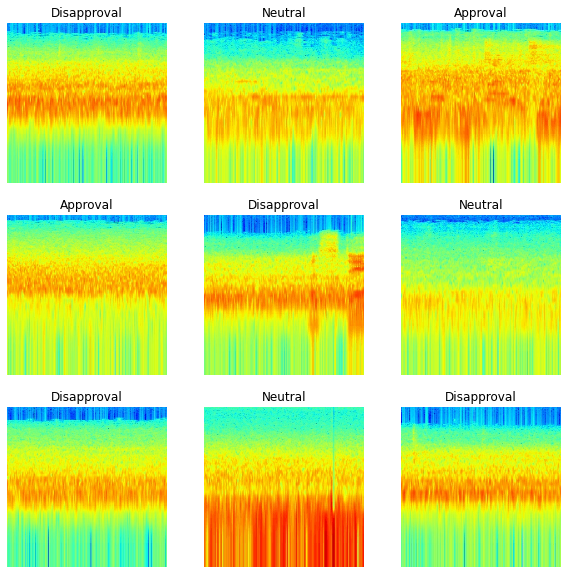

In [17]:
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [18]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

In [19]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [20]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [21]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [22]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [23]:
base_model.trainable = False

In [24]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [25]:
prediction_layer = tf.keras.layers.Dense(3)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 3)


In [26]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [27]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [28]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3843  

In [29]:
history = model.fit(train_ds, epochs=10)

Epoch 1/10
153/153 [==============================] - 99s 625ms/step - loss: 0.7326 - accuracy: 0.6929
Epoch 2/10
153/153 [==============================] - 96s 620ms/step - loss: 0.2690 - accuracy: 0.9185
Epoch 3/10
153/153 [==============================] - 96s 620ms/step - loss: 0.1890 - accuracy: 0.9461
Epoch 4/10
153/153 [==============================] - 96s 622ms/step - loss: 0.1595 - accuracy: 0.9584
Epoch 5/10
153/153 [==============================] - 96s 621ms/step - loss: 0.1395 - accuracy: 0.9617
Epoch 6/10
153/153 [==============================] - 95s 616ms/step - loss: 0.1189 - accuracy: 0.9648
Epoch 7/10
153/153 [==============================] - 95s 618ms/step - loss: 0.1094 - accuracy: 0.9654
Epoch 8/10
153/153 [==============================] - 96s 620ms/step - loss: 0.0998 - accuracy: 0.9716
Epoch 9/10
153/153 [==============================] - 95s 617ms/step - loss: 0.0933 - accuracy: 0.9746
Epoch 10/10
153/153 [==============================] - 95s 617ms/step - l

In [30]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

39/39 [==============================] - 26s 627ms/step - loss: 0.1659 - accuracy: 0.9469
Loss:  0.16592009365558624
Accuracy:  0.9468954205513


In [31]:
import time
timestamp = time.asctime().replace(' ', '_')
model.save('mobile_net_v2_' + timestamp + '.h5', save_format='h5')

In [32]:
f = open(logs_dir + 'log_v3.txt', 'a')
f.write(timestamp + '\tsplit: ' + str(TRAIN_PERCENTAGE)
+ '\taccuracy: ' + str(accuracy) + '\tloss: ' + str(loss) + '\n')
f.close()